In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
from glob import glob
from PIL import Image
import tifffile as tiff

In [28]:
images_path = '/content/drive/My Drive/Cellula_internship/satalite project/data/images'
labels_path ='/content/drive/My Drive/Cellula_internship/satalite project/data/labels'


## images preprocessing


In [29]:

image_files = glob(os.path.join(images_path, "*.tif"))

label_files = glob(os.path.join(labels_path, "*.png"))

# Count of total images
print(f"Total number of images: {len(image_files)}")
print(f"Total number of labels: {len(label_files)}")

Total number of images: 306
Total number of labels: 456


In [30]:
# Get all .tif images and .png labels
image_files = glob(os.path.join(images_path, "*.tif"))
label_files = glob(os.path.join(labels_path, "*.png"))

image_names = {os.path.splitext(os.path.basename(img))[0] for img in image_files}


unmatched_labels = []


for label_file in label_files:
    label_name = os.path.splitext(os.path.basename(label_file))[0]

    # Check if there is a matching image
    if label_name not in image_names:
        unmatched_labels.append(label_file)

print(f"Number of unmatched labels: {len(unmatched_labels)}")


Number of unmatched labels: 150


### Remove unmatched labels

In [31]:
# Update label_files list to only contain matched labels
remaining_label_files = [file for file in label_files if file not in unmatched_labels]


print(f"Number of remaining labels: {len(remaining_label_files)}")


Number of remaining labels: 306


In [32]:
# Count of total images
print(f"Total number of images: {len(image_files)}")
print(f"Total number of labels: {len(remaining_label_files)}")

Total number of images: 306
Total number of labels: 306


In [33]:
# Extract image names without the file extension
image_names = {os.path.splitext(os.path.basename(img))[0] for img in image_files}

# Extract label names without the file extension
label_names = {os.path.splitext(os.path.basename(lbl))[0] for lbl in remaining_label_files}


unmatched_images = [img for img in image_files if os.path.splitext(os.path.basename(img))[0] not in label_names]


print(f"Number of unmatched images: {len(unmatched_images)}")



Number of unmatched images: 0


In [34]:
def read_image_tiff(image_path):
    img = tiff.imread(image_path)
    return img


sample_image_file = image_files[0]

# Read the sample image with `tiff` library
print(f"Reading sample image: {sample_image_file}")
image_data = read_image_tiff(sample_image_file)

# Display image data properties
print(f"Image shape: {image_data.shape}")

Reading sample image: /content/drive/My Drive/Cellula_internship/satalite project/data/images/0.tif
Image shape: (128, 128, 12)


## Normalization

In [35]:
def reduce_channels_to_three(image_data):
    """
    Reduce the number of channels from 12 to 3 by averaging every 4 channels.
    """
    if image_data.shape[2] != 12:
        raise ValueError("Input image must have 12 channels.")

    # Average every 4 channels to reduce to 3 channels
    reduced_image = np.zeros((image_data.shape[0], image_data.shape[1], 3), dtype=np.float32)
    for i in range(3):
        reduced_image[:, :, i] = np.mean(image_data[:, :, i*4:(i+1)*4], axis=2)

    return reduced_image


In [36]:
def normalize_image_channels(image_data):
    """
    Normalize each channel of the image data.
    """
    normalized_image = np.zeros_like(image_data, dtype=np.float32)
    for i in range(image_data.shape[2]):
        channel = image_data[:, :, i]
        max_value = np.max(channel)
        if max_value > 0:
            normalized_image[:, :, i] = channel / max_value
        else:
            normalized_image[:, :, i] = channel
    return normalized_image

def load_and_normalize_images(image_files, label_files):
    """
    Load and normalize images and their corresponding label masks.
    """
    image_data_list = []
    labels_list = []

    # Extract image names without extension
    image_names = {os.path.splitext(os.path.basename(img))[0] for img in image_files}
    label_names = {os.path.splitext(os.path.basename(lbl))[0] for lbl in label_files}

    for image_file in image_files:
        image_name = os.path.splitext(os.path.basename(image_file))[0]
        if image_name in label_names:  # Check if there's a corresponding label
            try:
                image_data = tiff.imread(image_file)
                normalized_image = normalize_image_channels(image_data)

                # Reduce channels to 3
                reduced_image = reduce_channels_to_three(normalized_image)
                # Alternatively, you can use `select_three_channels` function:
                # reduced_image = select_three_channels(normalized_image)

                label_file = os.path.join(labels_path, image_name + ".png")
                label_mask = np.array(Image.open(label_file), dtype=np.float32)

                label_mask = label_mask / np.max(label_mask) if np.max(label_mask) > 0 else label_mask

                # Store reduced image and label mask
                image_data_list.append(reduced_image)
                labels_list.append(label_mask)

            except Exception as e:
                print(f"Error processing {image_file}: {e}")

    return np.array(image_data_list), np.array(labels_list)

In [37]:
# Load and normalize images
image_data_list, labels_list = load_and_normalize_images(image_files, remaining_label_files)

In [38]:
# Convert lists to numpy arrays for easier manipulation
image_data_array = np.array(image_data_list)
labels_array = np.array(labels_list)

In [39]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 244
Validation set size: 62


## visualization

In [40]:
def visualize_image_and_mask(image_path, mask_path):

    image_data = tiff.imread(image_path)
    mask_data = Image.open(mask_path)

    # Extract RGB channels from the image
    if image_data.shape[2] >= 3:
        rgb_image = image_data[:, :, :3]
    else:
        rgb_image = image_data

    # Convert to uint8 for visualization
    rgb_image = (rgb_image * 255).astype(np.uint8)
    mask_data = np.array(mask_data)


    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(rgb_image)
    ax[0].set_title('Sample Image')
    ax[0].axis('off')

    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

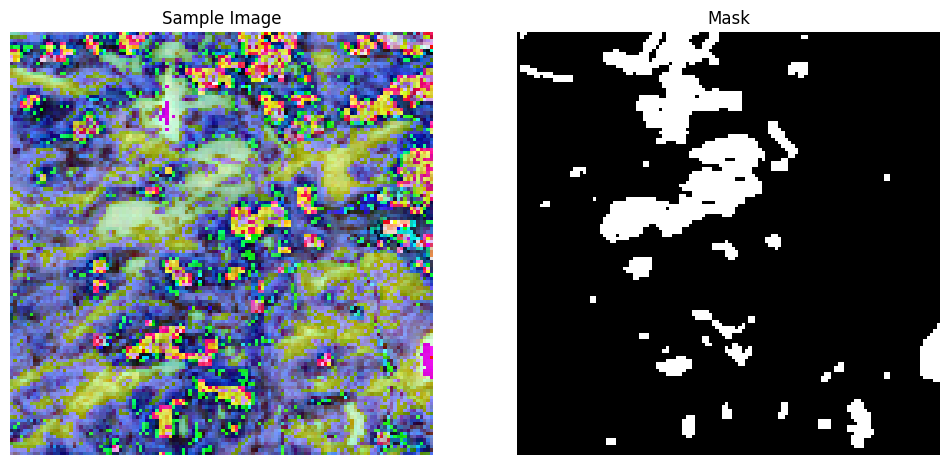

In [41]:

sample_image_file = glob(os.path.join(images_path, "*.tif"))[0]
sample_label_file = os.path.join(labels_path, os.path.splitext(os.path.basename(sample_image_file))[0] + ".png")


visualize_image_and_mask(sample_image_file, sample_label_file)

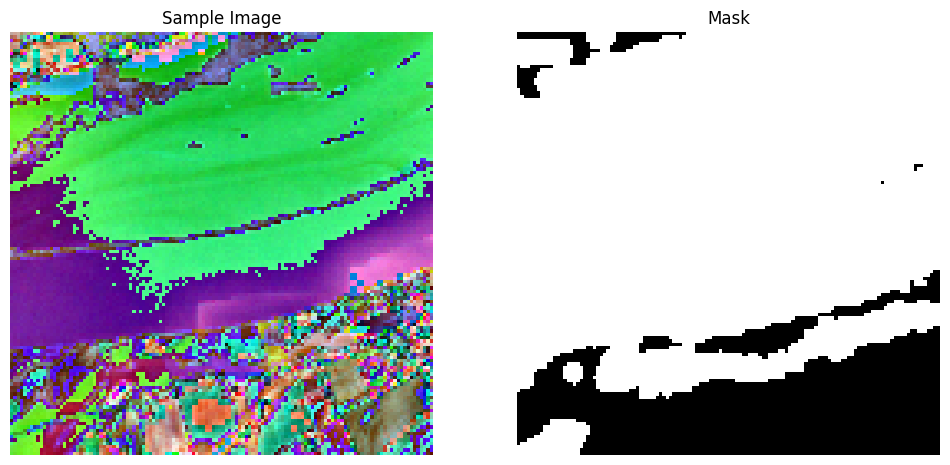

In [42]:
sample_image_file = glob(os.path.join(images_path, "*.tif"))[10]
sample_label_file = os.path.join(labels_path, os.path.splitext(os.path.basename(sample_image_file))[0] + ".png")


visualize_image_and_mask(sample_image_file, sample_label_file)

## Modeling U-net

In [43]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
def unet_model_with_pretrained_encoder(input_size=(128, 128, 3), num_classes=1):
    # Pre-trained VGG16 as the encoder
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

    # Freeze VGG16 layers to retain pre-trained weights
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder
    c1 = vgg16.get_layer("block1_conv2").output  # (64, 128, 128)
    p1 = vgg16.get_layer("block1_pool").output   # (64, 64, 64)

    c2 = vgg16.get_layer("block2_conv2").output  # (128, 64, 64)
    p2 = vgg16.get_layer("block2_pool").output   # (128, 32, 32)

    c3 = vgg16.get_layer("block3_conv3").output  # (256, 32, 32)
    p3 = vgg16.get_layer("block3_pool").output   # (256, 16, 16)

    c4 = vgg16.get_layer("block4_conv3").output  # (512, 16, 16)
    p4 = vgg16.get_layer("block4_pool").output   # (512, 8, 8)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

In [45]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.0  # To avoid division by zero
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [55]:
# Use the new U-Net model with pre-trained encoder
model = unet_model_with_pretrained_encoder(input_size=(128, 128, 3), num_classes=1)
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])


In [56]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [57]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6853 - loss: 1.0586 - val_accuracy: 0.8682 - val_loss: 0.6083
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.8536 - loss: 0.6172 - val_accuracy: 0.8715 - val_loss: 0.5898
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.8615 - loss: 0.6105 - val_accuracy: 0.8780 - val_loss: 0.5788
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.8495 - loss: 0.8065 - val_accuracy: 0.8492 - val_loss: 0.6373
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.8641 - loss: 0.5427 - val_accuracy: 0.8805 - val_loss: 0.5699
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8713 - loss: 0.5473 - val_accuracy: 0.8821 - val_loss: 0.5560
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.8714 - loss: 0.6116 - val_accuracy: 0.8894 - val_loss: 0.5536
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.8812 - loss: 0.4266 - val_accuracy: 0.8834 - val_loss: 0

In [58]:
print(type(X_train), X_train.dtype, X_train.shape)
print(type(y_train), y_train.dtype, y_train.shape)
print(type(X_val), X_val.dtype, X_val.shape)
print(type(y_val), y_val.dtype, y_val.shape)


<class 'numpy.ndarray'> float32 (244, 128, 128, 3)
<class 'numpy.ndarray'> float32 (244, 128, 128)
<class 'numpy.ndarray'> float32 (62, 128, 128, 3)
<class 'numpy.ndarray'> float32 (62, 128, 128)


In [59]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9084 - loss: 0.2676
Validation Loss: 0.2682623565196991
Validation Accuracy: 0.9076488614082336


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/My Drive/Cellula_internship/satalite project/UNet_Model.h5')